In [1]:
import underworld as uw
import glucifer
import numpy as np

In [2]:
# create periodic mesh
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), maxCoord=(1,1), periodic=(True,False))

In [3]:
velocity = mesh.add_variable( 2)

In [4]:
# setup shear
velocity.data[:] = (0.,0.)
velocity.data[:,0] = 2.*mesh.data[:,1]


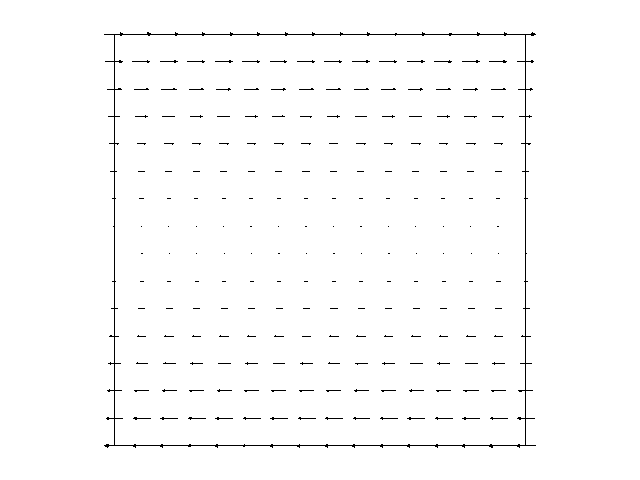

In [5]:
fig = glucifer.Figure()
fig.append( glucifer.objects.VectorArrows(mesh,velocity, scaling=0.05))
fig.show()

In [6]:
swarm = uw.swarm.Swarm(mesh)
normal = swarm.add_variable('double',2)
swarm.populate_using_layout(uw.swarm.layouts.GlobalSpaceFillerLayout(swarm,20))

In [7]:
fig.append(glucifer.objects.Points(swarm,pointSize=3., pointType=1, colourBar=False))


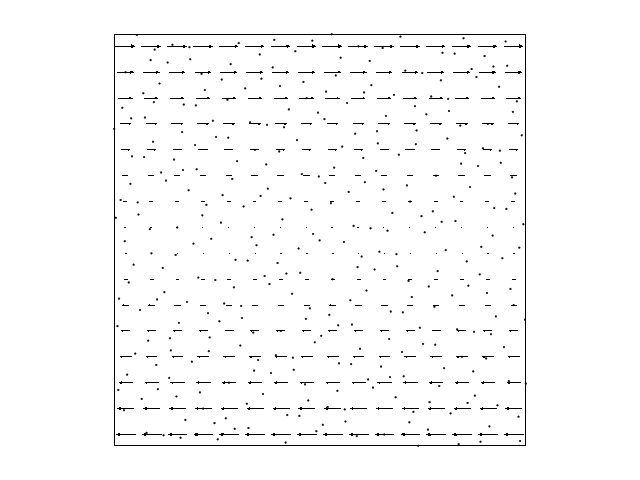

In [8]:
fig.show()

In [9]:
# initialise to point upwards
normal.data[:] = (1.,0.)

In [10]:
# cast to mesh so we can see
cast_var = mesh.add_variable(2)
cast = uw.utils.MeshVariable_Projection(cast_var,normal)

In [11]:
# viz 
normal_fig = glucifer.Figure()
normal_fig.append(glucifer.objects.VectorArrows(mesh,cast_var,scaling=0.001))


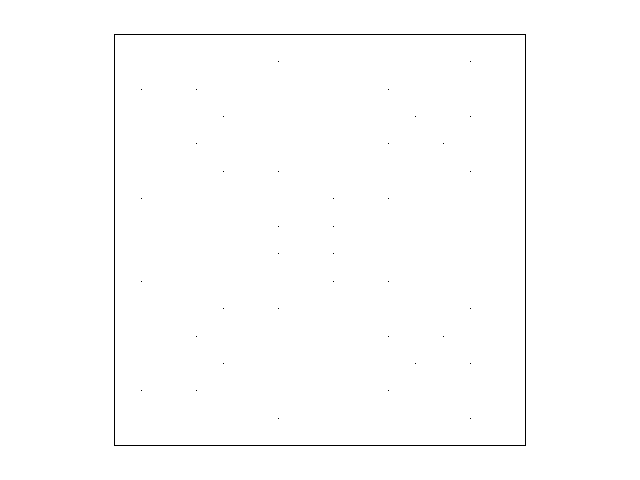

In [12]:
cast.solve()
normal_fig.show()

In [13]:
# just use advector system to get some reasonable dt
advector = uw.systems.SwarmAdvector(velocity,swarm)
dt = advector.get_max_dt()
# dt = 0.05

In [14]:
# get grad on all particles.. particles are not moving, and velocity is fixed, so only need to do this once.
velgrad = velocity.fn_gradient.evaluate(swarm)

In [15]:
time = 0.
maxtime = 100.
while time<maxtime:
    # expected angle
    angle = 0.5 * np.pi - np.arctan2(1.,2.*time)
    # director angles
    angleDirector = np.arctan2(-normal.data[:,1],normal.data[:,0])
    # angle errors
    angleError = angle - angleDirector

    # calculate $\dot n_i = -L_{ji} n_j$
    n_dot_x = -(velgrad[:,0]*normal.data[:,0] + velgrad[:,2]*normal.data[:,1])
    n_dot_y = -(velgrad[:,1]*normal.data[:,0] + velgrad[:,3]*normal.data[:,1])
    # apply forward euler
    normal.data[:,0] += dt*n_dot_x
    normal.data[:,1] += dt*n_dot_y

    time += dt
    
    # check if any angles not as expected
    if (np.abs(angleError) > 1e-15).any():
        raise RuntimeError("Director test failed.")


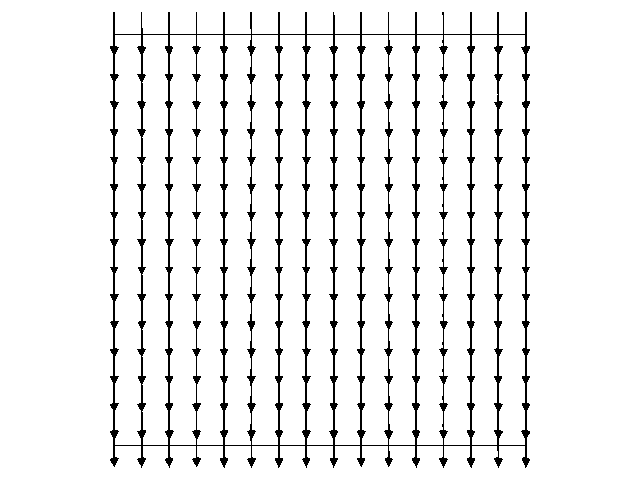

In [16]:
cast.solve()
normal_fig.show()